In [1]:
import ROOT
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import glob
%jsroot
from tqdm import tqdm
from array import array
import itertools
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import pickle

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from matplotlib.lines import Line2D

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DynamicEdgeConv, TransformerConv, Set2Set, GlobalAttention
from torch_geometric.utils import to_dense_batch, dense_to_sparse
from torch_geometric.data import Batch
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import radius_graph
from torch_geometric.nn import knn_graph
import torch.nn.functional as F
from math import acos, degrees

from torch import nn
from torch_geometric.nn import (
    DynamicEdgeConv,
    GATConv,
    global_mean_pool,
    knn_graph
)
from torch_geometric.utils import to_dense_batch
import matplotlib.patches as mpatches
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch_geometric.nn import JumpingKnowledge
import warnings


Welcome to JupyROOT 6.30/04


In [2]:
layout_file = ROOT.TFile("/mnt/e/testML/pie/run00000-00.root")
geohelper = layout_file.Get("PIMCGeoHelper")
layout = geohelper.GetLayout("CALORIMETER", "TP2")

In [3]:
pdg_to_idx = {pdg: i for i, pdg in enumerate([211,-13,-11,11,98105])}
# Bitmask constants (1 bit per particle type)
PION      = 0b00001  # 1
MUON      = 0b00010  # 2
POSITRON  = 0b00100  # 4
ELECTRON  = 0b01000  # 8
OTHER     = 0b10000  # 16

def pdg_to_mask(pdg_id):
    if pdg_id == 211: return PION
    elif pdg_id == -13: return MUON
    elif pdg_id == -11:       return POSITRON
    elif pdg_id == 11:        return ELECTRON
    else:                     return OTHER

MASK_TO_PDG = {
    0b00001: 211,    # pion
    0b00010: -13,     # muon
    0b00100: -11,    # positron
    0b01000: 11,     # electron
    0b10000: 98105    # other
    }

def decode_mask(mask):
    """
    Given a bitmask, return a list of PDG IDs it represents.
    """
    return [pdg for bit, pdg in MASK_TO_PDG.items() if mask & bit]

In [4]:
def smear(energy,energy_resolution):
    stdv = energy * energy_resolution
    smeared_energy = energy + np.random.normal(0,stdv)
    return smeared_energy

bounds = {
    "x": (-10.0, 10.0),
    "y": (-10.0, 10.0),
    "z": (0.0, 6.6),
}

def normalize(val, minv, maxv):
    return 2 * (val - minv) / (maxv - minv) - 1

In [5]:
def groupID(groupList):
    """
    This function takes in a list of groups of hits, and returns the unique PDG IDs
    associated with each group, based on bitmask encoding. A PDG ID is kept only if it
    appears in at least two hits in the group; if none do, all are kept.
    """
    unique_pdg_per_group = []

    for group in groupList:
        all_decoded_pdgs = []
        for hit in group:
            mask = int(hit[5])
            all_decoded_pdgs.extend(decode_mask(mask))

        pdg_counts = Counter(all_decoded_pdgs)
        unique_pdgs = [pdg for pdg, count in pdg_counts.items() if count >= 2]

        if not unique_pdgs:
            unique_pdgs = list(pdg_counts.keys())

        unique_pdg_per_group.append(unique_pdgs)

    return unique_pdg_per_group


def determine_event(time_groups, all_time_groups):
    event_with_origin = []
    inc_pos = 0

    # Always include the main pion groups (origin 0)
    for g in time_groups[:-1]:
        event_with_origin.append((np.array(g), 0))

    # 20% chance positron from time_groups (origin 0)
    if np.random.rand() < 0.2:
        inc_pos = 1
        event_with_origin.append((np.array(time_groups[-1]), 0))

    # Random event 1
    random_event_1 = all_time_groups[np.random.randint(len(all_time_groups))]
    if np.random.rand() < 0.2:
        for g in random_event_1[:-1]:
            event_with_origin.append((np.array(g), 1))
        if np.random.rand() < 0.2:
            inc_pos = 1
            event_with_origin.append((np.array(random_event_1[-1]), 1))

    # Random event 2
    random_event_2 = all_time_groups[np.random.randint(len(all_time_groups))]
    if np.random.rand() < 0.1:
        inc_pos = 1
        event_with_origin.append((np.array(random_event_2[-1]), 2))

    # If no positron, include main one
    if not inc_pos:
        event_with_origin.append((np.array(time_groups[-1]), 0))

    # Shuffle
    np.random.shuffle(event_with_origin)

    # Split back
    event_data = [item[0] for item in event_with_origin]   # list of np.ndarray
    event_origins = [item[1] for item in event_with_origin]

    return event_data, event_origins

def pion_start_position(data):
    # columns: [xory, z, energy, view0, view1, pion_group_energy]

    # x-view
    mask_x = data[:, 3] == 1
    x0, zx = None, None
    if np.any(mask_x):
        zxs = data[mask_x, 1]
        idx_x = np.argmin(zxs)
        zx = zxs[idx_x]
        x0 = data[mask_x, 0][idx_x]

    # y-view
    mask_y = data[:, 4] == 1
    y0, zy = None, None
    if np.any(mask_y):
        zys = data[mask_y, 1]
        idx_y = np.argmin(zys)
        zy = zys[idx_y]
        y0 = data[mask_y, 0][idx_y]

    # choose the smaller of the two z’s
    if zx is not None and zy is not None:
        z0 = min(zx, zy)
    else:
        z0 = zx if zy is None else zy

    return (x0, y0, z0)


def farthest_point(coords: torch.Tensor, ref: torch.Tensor) -> torch.Tensor:
    """
    coords: (N,3) tensor of candidate points
    ref: (3,) tensor of reference point
    Returns: (3,) tensor of the farthest point
    """
    dists = torch.sum((coords - ref) ** 2, dim=1)
    idx = torch.argmax(dists)  # farthest instead of closest
    return coords[idx]

# Slopes + residuals
def robust_slope(z_vals, lat_vals):
    if len(z_vals)<2:
        return 0.0, 0.0
    a,b = np.polyfit(z_vals, lat_vals, 1)
    residuals = lat_vals - (a*z_vals + b)
    rms = np.sqrt(np.mean(residuals**2))
    return a, rms

def make_group_feature_vector(hits, endpoint1, endpoint2, pdg_id):
    """
    Compute a fixed-length feature vector for a time group.
    
    Parameters
    ----------
    hits : np.ndarray, shape (N,6)
        Columns: [x_or_y, z, E, view0, view1, group_energy]
    endpoint1 : tuple, (z1, x1, y1)
    endpoint2 : tuple, (z2, x2, y2)
    pdg_id : int
        Particle type
    
    Returns
    -------
    feature_vec : np.ndarray, shape (14,)
        Order:
        [centroid_z, centroid_x, centroid_y,
         x_std, y_std,
         slope_x, resid_x, slope_y, resid_y,
         energy_frac_front, energy_frac_back,
         endpoint1_z, endpoint2_z,
         pdg_id]
    """
    # Extract hit columns
    lat = hits[:,0]
    z   = hits[:,1]
    E   = hits[:,2]
    view0 = hits[:,3]
    view1 = hits[:,4]

    # Determine axis: 0=x, 1=y
    axis = np.where(view0==1, 0, 1)

    x_hits = hits[axis==0]
    y_hits = hits[axis==1]

    # Centroids
    centroid_z = np.average(z, weights=E)
    centroid_x = np.average(x_hits[:,0], weights=x_hits[:,2]) if len(x_hits)>0 else 0.0
    centroid_y = np.average(y_hits[:,0], weights=y_hits[:,2]) if len(y_hits)>0 else 0.0

    # Spread
    x_std = np.std(x_hits[:,0]) if len(x_hits)>0 else 20/np.sqrt(12)
    y_std = np.std(y_hits[:,0]) if len(y_hits)>0 else 20/np.sqrt(12)

    slope_x, resid_x = robust_slope(x_hits[:,1], x_hits[:,0])
    slope_y, resid_y = robust_slope(y_hits[:,1], y_hits[:,0]) 

    # Energy front/back fraction
    z_sort_idx = np.argsort(z)
    sorted_hits = hits[z_sort_idx]
    mid = len(sorted_hits)//2
    E_front = sorted_hits[:mid,2].sum()
    E_back  = sorted_hits[mid:,2].sum()
    total_E = E.sum()
    energy_frac_front = E_front / total_E if total_E>0 else 0
    energy_frac_back  = E_back  / total_E if total_E>0 else 0

    #print(type())

    # Construct fixed-length vector
    #feature_vec = np.array([
    #    centroid_z, centroid_x, centroid_y,
    #    x_std, y_std,
    #    slope_x, resid_x, slope_y, resid_y,
    #    energy_frac_front, energy_frac_back,
    #    *endpoint1, *endpoint2,
    #    *pdg_id
    #], dtype=np.float32)

    feature_vec = np.array([
        centroid_z, centroid_x, centroid_y,
        x_std, y_std,
        slope_x, slope_y,
        energy_frac_front, energy_frac_back,
        *endpoint1, *endpoint2,
        *pdg_id
    ], dtype=np.float32)

    return feature_vec

warnings.simplefilter('ignore', np.RankWarning)

In [6]:
def chain_all_models(all_time_groups, model_classifier, model_splitter, model_piStop, model_posAngle, model_endpointsMu, model_endpointsMIP, num_samples=5):
    with torch.no_grad():
        all_events = []
        all_group_origins = []
        all_angles = []
        all_pionStops = []
        all_event_features = []
        for event_index, time_groups in enumerate(all_time_groups):
            # Determine the event composition
            event, group_origins = determine_event(time_groups, all_time_groups)
            posAngles = []
            pionStops = []
            event_features = []

            #print(time_groups)
            #print(event)

            #tg_pdgs = [print(group[:, 11]) for group in time_groups]
            #print()
            #event_pdgs = [print(group[:, 11]) for group in event]

            for group, origin in zip(event,group_origins):

                #This first block gets relevant features for classification and then classifies the group

                #print(len(group), origin)
                coords = group[:, 0]
                zs = group[:, 1]
                strip_types = group[:, 2].astype(int)
                energy = group[:, 3]
                times = group[:, 4]
                pdgs = group[:, 5].astype(int)
                event_number = group[:, 6]
                true_x = group[:, 7]
                true_y = group[:, 8]
                true_z = group[:, 9]
                true_time = group[:, 10]
                group_energy = group[:, 11]

                view0 = (strip_types == 0).astype(float)
                view1 = (strip_types == 1).astype(float)

                event_id = torch.tensor(origin, dtype=torch.float)

                x_stack = np.stack([coords, zs, energy, view0, view1], axis=1)
                #x = torch.tensor(x_stack, dtype=torch.float)
                #group2classify = Data(x=x, event_id=event_id, group_energy=torch.tensor([[group_energy[0]]], dtype=torch.float))
                #group2classify = Data(x=x, event_id=event_id, dtype=torch.float))
                #group2classify.batch = torch.zeros(group2classify.x.shape[0], dtype=torch.long)
                
                particle_stack = np.stack([coords, zs, energy, view0, view1, group_energy], axis=1)
                particle_track = torch.tensor(particle_stack, dtype=torch.float)
                data_particle = Data(x=particle_track)
                data_particle.batch = torch.zeros(data_particle.x.shape[0], dtype=torch.long)
                
                preds = torch.stack([torch.sigmoid(model_classifier(data_particle)) for _ in range(num_samples)], dim=0)
                #print(pdgs)
                final_pred = preds.mean(dim=0)
                recon_pdgs = (final_pred > 0.5).cpu().numpy().astype(int)[0]
                #print(recon_pdgs)

                #Check if the group has a pion and muon; if so, we try to split the group to get a pion stop
                if recon_pdgs[0] == 1 and recon_pdgs[1] == 1 and recon_pdgs[2] == 0:

                    #print(pdgs)
                    logits_s = []
                    for _ in range(num_samples):
                        logits_s.append(model_splitter(data_particle))
                    stacked = torch.stack(logits_s, dim=0)     # [S, N, C]
                    mean_logits = stacked.mean(0)              # [N, C]
                    probs = F.softmax(mean_logits, dim=1)      # [N, C]
                    preds = probs.argmax(1).cpu().numpy()

                    pion_hit_mask = (preds == 0)
                    muon_hit_mask = (preds == 1)
                    piandmuon_hit_mask = (preds == 2)

                    #pion_hit_mask = np.where(pion_mask)[0]
                    #muon_hit_mask = np.where(muon_mask)[0]
                    #piandmuon_hit_mask = np.where(piandmuon_mask)[0]


                    #xory      = x_stack[:, 0]      # x or y
                    #zs        = x_stack[:, 1]      # z
                    #energies  = x_stack[:, 2]   # energy
                    #view0     = x_stack[:, 3].astype(bool)
                    #view1     = x_stack[:, 4].astype(bool)

                    #Divide hit energy of shared hits by 2 because they are shared between pion and muon
                    energy[piandmuon_hit_mask] = energy[piandmuon_hit_mask] / 2

                    pion_group_energy = (energy[pion_hit_mask | piandmuon_hit_mask].sum()) * np.ones_like(energy[pion_hit_mask | piandmuon_hit_mask])

                    muon_group_energy = (energy[muon_hit_mask | piandmuon_hit_mask].sum()) * np.ones_like(energy[muon_hit_mask | piandmuon_hit_mask])


                    pion_stack = np.stack([coords[pion_hit_mask | piandmuon_hit_mask], zs[pion_hit_mask | piandmuon_hit_mask], energy[pion_hit_mask | piandmuon_hit_mask], view0[pion_hit_mask | piandmuon_hit_mask], view1[pion_hit_mask | piandmuon_hit_mask], pion_group_energy], axis=1)

                    muon_stack = np.stack([coords[muon_hit_mask | piandmuon_hit_mask], zs[muon_hit_mask | piandmuon_hit_mask], energy[muon_hit_mask | piandmuon_hit_mask], view0[muon_hit_mask | piandmuon_hit_mask], view1[muon_hit_mask | piandmuon_hit_mask], muon_group_energy], axis=1)

                    pion_track = torch.tensor(pion_stack, dtype=torch.float)
                    muon_track = torch.tensor(muon_stack, dtype=torch.float)

                    data_pion = Data(x=pion_track)
                    data_pion.batch = torch.zeros(pion_track.shape[0], dtype=torch.long)
                    data_muon = Data(x=muon_track, group_type=torch.tensor([2], dtype=torch.int))
                    data_muon.batch = torch.zeros(muon_track.shape[0], dtype=torch.long)

                    preds_pion = torch.stack([model_piStop(data_pion) for _ in range(num_samples)], dim=0)
                    pion_stop = preds_pion.mean(dim=0)
                    pionStops.append([pion_stop,origin])
                    # Probably should have sorted the endpoints before averaging in training, this is something to test later

                    #data_particle = Data(x=particle_track, group_type=torch.tensor([-13], dtype=torch.int))
                    #data_particle.batch = torch.zeros(data_particle.x.shape[0], dtype=torch.long)

                    if sum(muon_hit_mask | piandmuon_hit_mask) < 2:
                        pion_start = pion_start_position(x_stack)
                        muon_stop = pion_stop.squeeze(0)

                    else:

                        preds_muon = torch.stack([model_endpointsMu(data_muon) for _ in range(num_samples)], dim=0)
                        muon_endpoints = preds_muon.mean(dim=0)

                        pion_start = pion_start_position(x_stack)
                        muon_stop = farthest_point(muon_endpoints[0], pion_stop[0])

                    # Now we have the pion stop and muon endpoints,  we can move to computing summary information about the time group that will be used for pattern finding

                    group_features = make_group_feature_vector(x_stack, pion_start, muon_stop, recon_pdgs)
                    event_features.append(group_features)

                else:
                    #continue

                    #xory      = x[:, 0].cpu().numpy()       # x or y
                    #zs        = x[:, 1].cpu().numpy()       # z
                    #energies  = x[:, 2].cpu().numpy()       # energy
                    #view0     = x[:, 3].cpu().numpy().astype(bool)
                    #view1     = x[:, 4].cpu().numpy().astype(bool)

                    #group_energy = (energies.sum()) * np.ones_like(energies)

                    #particle_stack = np.stack([xory, zs, energies, view0, view1, group_energy], axis=1)
                    #particle_track = torch.tensor(particle_stack, dtype=torch.float)
                    #data_particle = Data(x=particle_track)
                    
                    if recon_pdgs[2] == 1: # positron
                        if len(coords) < 2:
                            if strip_types[0]:
                                endpoints = [(0,coords[0],zs[0]),(0,coords[0],zs[0])]
                            else:
                                endpoints = [(coords[0],0,zs[0]),(coords[0],0,zs[0])]

                            print(endpoints)
                        else:
                            data_particle.group_type = torch.tensor([4], dtype=torch.int)
                            endpoints = torch.stack([model_endpointsMIP(data_particle).mean(dim=0) for _ in range(num_samples)], dim=0)
                            endpoints = endpoints.mean(dim=0).squeeze(0)
                        #print(endpoints)

                        # To get the positron angle we need the pion stop to break the degeneracy of the direction, so this must come after pattern finding
                        #posAngle = torch.stack([model_posAngle(data_particle) for _ in range(num_samples)], dim=0)
                        #posAngle = posAngle.mean(dim=0)
                        #posAngles.append([posAngle,origin])
                    elif recon_pdgs[0] == 1: # pion
                        piStop = torch.stack([model_piStop(data_particle) for _ in range(num_samples)], dim=0)
                        piStop = piStop.mean(dim=0)
                        pionStops.append([piStop,origin])
                        piStart = pion_start_position(particle_stack)
                        #print(piStart, piStop)
                        endpoints = [piStart, piStop.squeeze(0)]
                    elif recon_pdgs[1] == 1: # muon
                        #print(pdgs)
                        if len(coords) < 2:
                            if strip_types[0]:
                                endpoints = [(0,coords[0],zs[0]),(0,coords[0],zs[0])]
                            else:
                                endpoints = [(coords[0],0,zs[0]),(coords[0],0,zs[0])]

                            print(endpoints)
                        else:
                            data_particle.group_type = torch.tensor([2], dtype=torch.int)
                            endpoints = torch.stack([model_endpointsMu(data_particle) for _ in range(num_samples)], dim=0)
                            endpoints = endpoints.mean(dim=0)
                            endpoints = endpoints.squeeze(0)
                        #print(endpoints)

                    group_features = make_group_feature_vector(x_stack, endpoints[0], endpoints[1], recon_pdgs)
                    event_features.append(group_features)

            all_events.append(event)
            all_group_origins.append(group_origins)
            all_angles.append(posAngles)
            all_pionStops.append(pionStops)
            all_event_features.append(event_features)
    return all_events, all_group_origins, all_angles, all_pionStops, all_event_features

In [7]:
# Load in the time groups in chunks of 10000 
files = sorted(glob.glob("/mnt/e/testML/pimuTimeGroups/mainTimeGroups_*.npy"),
               key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[-1]))

In [8]:
#leGroup = [np.load(f, allow_pickle=True) for f in files]

In [9]:
class FullTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x

class EPlusAnglePredictorGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.block1    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.pool      = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(hidden_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )
        # replace the 3‐output head with a 3‐D direction head:
        self.dir_head = nn.Sequential(
            nn.Linear(hidden_channels + 3, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3)
        )

    def forward(self, data):
        x, batch = self.lin_embed(data.x), data.batch

        # Build a complete graph within each batch element
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)
        x_group = self.pool(x, batch)

        # Append pion_stop to pooled group features
        pion_stop = data.pion_stop  # shape: [batch_size, 3]
        pion_dir = F.normalize(data.pion_stop, p=2, dim=1)
        x_combined = torch.cat([x_group, pion_dir], dim=1)  # [batch_size, hidden_channels + 3]

        # raw 3‐vector
        v = self.dir_head(x_combined)
        # normalize to unit length
        v = F.normalize(v, p=2, dim=1)
        return v  # shape: [num_events, 3] v^=(sinθcosϕ,sinθsinϕ,cosθ).

class PionStopPredictorGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.block1 = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2 = FullTransformerBlock(hidden_channels, heads, dropout)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3)  # 3D stop position: x, y, z
        )
        self.pool = GlobalAttention(
            gate_nn=torch.nn.Sequential(
                nn.Linear(hidden_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )

    def forward(self, data):
        x = self.lin_embed(data.x)  # shape: [N, hidden_channels]
        batch = data.batch          # shape: [N]

        # Build a complete graph within each batch element
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        # Transformer blocks
        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)

        # Global pooling to get per-group embedding
        x_group = self.pool(x, batch) # shape: [num_groups, hidden_channels]

        # Predict 3D pion stop position
        return self.regressor(x_group)  # shape: [num_groups, 3]

class PionMuonSplitterGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, dropout=0.2):
        super().__init__()
        # Initial embedding of node features
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        # Two full transformer blocks
        self.block1 = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2 = FullTransformerBlock(hidden_channels, heads, dropout)
        # Final classifier: [is_pion, is_muon, is_both]
        self.output = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), 
            nn.ReLU(),
            nn.Linear(hidden_channels, 3) # 3 for pion, muon, positron
        )

    def forward(self, data):
        x = self.lin_embed(data.x)  # [N, hidden_channels]
        batch = data.batch

        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)

        out = self.output(x)
        return out

class FullTransformerBlockClassifier(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            beta=True,
            edge_dim=4
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x

class GroupClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, num_blocks=2, dropout=0.2):
        super().__init__()
        # Input embedding
        self.lin_embed = nn.Linear(in_channels, hidden_channels)

        # Stacked Transformer blocks (edge-aware)
        self.blocks = nn.ModuleList([
            FullTransformerBlockClassifier(hidden_channels, heads, dropout) for _ in range(num_blocks)
        ])

        # Jumping Knowledge across all blocks
        self.jk_layer = JumpingKnowledge(mode='cat')
        jk_output_channels = hidden_channels * num_blocks

        # Global Attention pooling
        self.pool = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(jk_output_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )

        # Final classifier (append group_energy)
        self.output = nn.Sequential(
            nn.Linear(jk_output_channels, hidden_channels * 2), # extra 1 for group_energy
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3)  # pion, muon, positron
        )

    def forward(self, data):
        x_raw = data.x
        x = self.lin_embed(x_raw)         # [N, hidden_channels]
        batch = data.batch                # [N]

        # ---- Build complete graph per batch element ----
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # [2, E]

        # ---- Build edge attributes ----
        pos2d = x_raw[:, :2]                          # first 2 coords
        delta = pos2d[edge_index[1]] - pos2d[edge_index[0]]  # [E, 2]

        energy = x_raw[:, 2]
        dE = (energy[edge_index[1]] - energy[edge_index[0]]).unsqueeze(1)  # [E, 1]

        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        same_view = ((view0[edge_index[1]] * view0[edge_index[0]]) +
                     (view1[edge_index[1]] * view1[edge_index[0]])).unsqueeze(1)  # [E, 1]

        edge_attr = torch.cat([delta, dE, same_view], dim=1)  # [E, 4]

        # ---- Transformer blocks with JumpingKnowledge ----
        layer_outputs = []
        for block in self.blocks:
            x = block(x, edge_index, edge_attr)  # use edge_attr here
            layer_outputs.append(x)

        xjk = self.jk_layer(layer_outputs)       # [N, hidden_channels * num_blocks]

        # ---- Pool to group-level ----
        x_group = self.pool(xjk, batch)          # [B, hidden_channels * num_blocks]

        return self.output(x_group)   

class FullTransformerBlockEndpointFinder(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            beta=True,
            edge_dim=4
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x

class EndpointFinderGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4,num_blocks=2, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.blocks = nn.ModuleList([
            FullTransformerBlockEndpointFinder(hidden_channels, heads, dropout) for _ in range(num_blocks)
        ])

        self.jk_layer = JumpingKnowledge(mode='cat')
        jk_output_channels = hidden_channels * num_blocks

        self.regressor = nn.Sequential(
            nn.Linear(jk_output_channels + 1, hidden_channels * 2),
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 6)
        )
        self.pool = GlobalAttention(
            gate_nn=torch.nn.Sequential(
                nn.Linear(jk_output_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )

    def forward(self, data):
        x_raw = data.x
        x = self.lin_embed(x_raw)         # shape: [N, hidden_channels]
        batch = data.batch                # shape: [N]

        pos2d = x_raw[:, :2]              # [coord, z]
        energy = x_raw[:, 2]
        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        
        # Use to_dense_batch to get a padded representation and a mask
        # We only need the mask, so we can use a small tensor like batch for efficiency
        _, mask = to_dense_batch(data.batch, data.batch) # mask shape: [B, N_max]
        B, N_max = mask.shape

        # --- Build Adjacency Matrix in the Dense space ---
        # Create a fully-connected adjacency matrix for each graph in the batch
        adj = torch.ones(B, N_max, N_max, device=x.device)

        # Mask out connections from/to padding nodes so they are not included
        adj.masked_fill_(~mask.unsqueeze(1), 0)
        adj.masked_fill_(~mask.unsqueeze(2), 0)

        # Remove self-loops (a node doesn't have an edge to itself)
        adj.diagonal(dim1=-2, dim2=-1).fill_(0)

        # --- Map Dense Edges back to Sparse Indices ---
        # Find the coordinates of all existing edges in the dense batch: (batch_idx, local_row, local_col)
        b, i, j = adj.nonzero(as_tuple=True)

        # To map these back to the original 'x_raw' tensor, we need a cumulative sum of event sizes.
        # This gives us the starting index for each event in the original flat tensor.
        unique_batches, counts = torch.unique(data.batch, return_counts=True)
        cumsum = torch.cat([counts.new_zeros(1), counts.cumsum(dim=0)])

        # Calculate the final 'edge_index' in the sparse (global) space
        # global_row = start_of_event_in_x_raw + local_row_in_event
        row = cumsum[b] + i
        col = cumsum[b] + j
        edge_index = torch.stack([row, col], dim=0)
        #ed2 = edge_index

        #ed1_sorted = ed1[:, ed1[0].argsort()]
        #ed2_sorted = ed2[:, ed2[0].argsort()]

        #assert torch.equal(ed1_sorted, ed2_sorted), \
        #    "Edge indices do not match after conversion from dense to sparse!"

        num_nodes = x_raw.size(0)
        assert edge_index.max().item() < num_nodes, \
        f"Index out of bounds! Max generated index is {edge_index.max().item()}, but there are only {num_nodes} nodes."

        # --- Build Edge Attributes using the CORRECT sparse indices ---
        # This section is now safe because 'row' and 'col' are valid indices for x_raw
        pos2d = x_raw[:, :2]
        delta = pos2d[col] - pos2d[row]  # shape: [E, 2]

        energy = x_raw[:, 2]
        dE = (energy[col] - energy[row]).unsqueeze(1)  # [E, 1]

        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        same_view = ((view0[col] * view0[row]) + (view1[col] * view1[row])).unsqueeze(1)  # [E, 1]

        edge_attr = torch.cat([delta, dE, same_view], dim=1)  # [E, 4]

        # Transformer blocks (supporting edge_attr now)
        layer_outputs = []
        for block in self.blocks:
            x = block(x, edge_index, edge_attr)
            layer_outputs.append(x)

        # Jumping Knowledge Layer
        xjk = self.jk_layer(layer_outputs)  # shape: [num_groups, hidden_channels * num_blocks]
        # Pooling to get group representations
        x_group = self.pool(xjk, batch)  # shape: [num_groups, hidden_channels * num_blocks]

        # Append group classification
        group_type = data.group_type.unsqueeze(1).float()  # shape: [num_groups, 1]
        x_group_comb = torch.cat([x_group, group_type], dim=1)


        return self.regressor(x_group_comb).view(-1, 2, 3) # [batch_size, 2, 3]

In [10]:
angle_model = EPlusAnglePredictorGNN(in_channels=5, hidden_channels=200)
angle_model.load_state_dict(torch.load('/mnt/e/testML/positronAngleV1.pth'))

piStop_model = PionStopPredictorGNN(in_channels=6, hidden_channels=200)
piStop_model.load_state_dict(torch.load('/mnt/e/testML/pionStopV3.pth'))

splitter_model = PionMuonSplitterGNN(in_channels=6, hidden_channels=256)
splitter_model.load_state_dict(torch.load('/mnt/e/testML/pimu_splitterV4.pth'))

classifier_model = GroupClassifier(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
classifier_model.load_state_dict(torch.load('/mnt/e/testML/groupClassifierV11.pth'))

eplus_endpoint_model = EndpointFinderGNN(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
eplus_endpoint_model.load_state_dict(torch.load('/mnt/e/testML/endpoint_finder_ePlus_V2.pth'))

muplus_endpoint_model = EndpointFinderGNN(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
muplus_endpoint_model.load_state_dict(torch.load('/mnt/e/testML/endpoint_finder_muPlus_V1.pth'))

/home/omar/miniconda3/envs/research/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


<All keys matched successfully>

In [11]:
classifier_model.train()
classifier_model = classifier_model.to("cpu")

splitter_model.train()
splitter_model = splitter_model.to("cpu")

piStop_model.train()
piStop_model = piStop_model.to("cpu")

angle_model.train()
angle_model = angle_model.to("cpu")

muplus_endpoint_model.train()
muplus_endpoint_model = muplus_endpoint_model.to("cpu")

eplus_endpoint_model.train()
eplus_endpoint_model = eplus_endpoint_model.to("cpu")

In [12]:
leGroup = np.load(files[0],allow_pickle=True)

In [13]:
# I should try to normalize the features before training

In [14]:
all_events, all_group_origins, all_angles, all_pionStops, all_event_features = chain_all_models(leGroup[:500], classifier_model, splitter_model, piStop_model, angle_model, muplus_endpoint_model, eplus_endpoint_model, num_samples=5)

[(0, 2.5, 3.5255000591278076), (0, 2.5, 3.5255000591278076)]
[(3.5, 0, 3.674499988555908), (3.5, 0, 3.674499988555908)]
[(0, 2.5, 3.5255000591278076), (0, 2.5, 3.5255000591278076)]
[(0, 2.5, 3.237499952316284), (0, 2.5, 3.237499952316284)]
[(6.699999809265137, 0, 3.674499988555908), (6.699999809265137, 0, 3.674499988555908)]
[(3.5, 0, 3.674499988555908), (3.5, 0, 3.674499988555908)]


In [16]:
print(all_event_features[1][0])

[ 2.4108658e+00 -1.0191456e+00 -1.1000000e+00  9.9215701e-02
  0.0000000e+00 -3.6276959e-02 -3.9345465e-17  3.6375278e-01
  6.3624722e-01 -1.1000000e+00 -1.1000000e+00 -6.9499999e-02
 -1.0976036e+00 -1.1868929e+00  3.9522941e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00]


In [15]:
max_features = np.ones(15)
min_features = np.ones(15)

for event in all_event_features:
    for feature_vec in event:
        for i, feature in enumerate(feature_vec):
            if i > 14:
                continue

            if feature < min_features[i]:
                min_features[i] = feature
            elif feature > max_features[i]:
                max_features[i] = feature

print("Feature mins: ", min_features)
print("Feature maxes: ", max_features)

normalized_features = []
for event in all_event_features:
    event_list = []
    for feature_vec in event:
        norm_feature_vec = np.zeros(18)
        for i, feature in enumerate(feature_vec):
            if i > 14:
                norm_feature_vec[i] = feature
            else:
                normed_val = (feature - min_features[i]) / (max_features[i] - min_features[i])
                norm_feature_vec[i] = normed_val
            
        event_list.append(norm_feature_vec)
    
    normalized_features.append(np.stack(event_list))


Feature mins:  [  0.74514234  -8.5757637   -9.36512375   0.           0.
 -15.62499428 -11.80555153   0.           0.09215294 -10.63476181
 -10.05219555  -0.0695     -10.38042259 -10.48979855  -0.09401278]
Feature maxes:  [ 5.8671627   9.07662487  9.01157665  5.77350283  5.77350283 24.17329216
 27.76387787  1.          1.         10.14969635 10.20085907  6.87846994
 10.01995182 10.53007984  4.84903765]


In [18]:
print(len(all_event_features[11][1]))

18


In [19]:
[length.shape if isinstance(length, np.ndarray) else len(length) for length in all_event_features[:10]]

[3, 3, 2, 5, 5, 5, 3, 3, 3, 3]

In [16]:
class TimeGroupDataset(Dataset):
    """
    items: each item is (features, event_ids)
      features: np.array or torch.tensor shape [n_groups, F]
      event_ids: iterable length n_groups of ints (labels; same-event if equal)
    """
    def __init__(self, feature_vec, event_vec):
        self.features = feature_vec
        self.event = event_vec

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features, event_ids = self.features[idx], self.event[idx]
        # ensure torch tensors
        features = np.array(features)
        features = torch.as_tensor(features, dtype=torch.float32)
        event_ids = np.asarray(event_ids)
        return features, event_ids

def collate_example_batch(batch):
    """
    Collate a list of (features, event_ids) into:
      X: [N_total, F]
      example_id: [N_total] indicating which example each node belongs to
      ptr: list of lengths for backmapping
      event_ids_flat: list/np array of event_ids flattened, used to build pair labels

    We must define our own batching because our number of time groups is variable
    """
    features_list, event_ids_list = zip(*batch)
    # compute counts
    counts = [f.shape[0] for f in features_list]
    example_id = []
    Xs = []
    event_ids_flat = []
    for i, (f, eids) in enumerate(zip(features_list, event_ids_list)):
        if f.shape[0] == 0:
            continue
        Xs.append(f)
        example_id.append(torch.full((f.shape[0],), i, dtype=torch.long))
        event_ids_flat.append(np.asarray(eids))  # keep numpy for equality checks later
    if len(Xs) == 0:
        return torch.empty(0), torch.empty(0, dtype=torch.long), [], []
    X = torch.cat(Xs, dim=0)                           # [N_total, F]
    example_id = torch.cat(example_id, dim=0)         # [N_total]
    return X, example_id, counts, event_ids_list      # event_ids_list keeps per-example labels

# ===== Model =====
class GroupAffinityModel(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, encoder_layers=2, dropout=0.1):
        super().__init__()
        # encoder MLP
        layers = []
        d = in_channels
        for i in range(encoder_layers):
            layers.append(nn.Linear(d, hidden_channels))
            layers.append(nn.LayerNorm(hidden_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            d = hidden_channels
        self.encoder = nn.Sequential(*layers)  # maps [N, in_channels] -> [N, hidden_channels]

        # optional self-attention / contextualizer (simple transformer encoder)
        self.use_transformer = True
        if self.use_transformer:
            # small transformer: batch_first=True in recent PyTorch
            enc_layer = nn.TransformerEncoderLayer(d_model=hidden_channels, nhead=4, dim_feedforward=hidden_channels*2, batch_first=True)
            self.transformer = nn.TransformerEncoder(enc_layer, num_layers=2)

        # pair scorer MLP
        # input per pair: [h_i, h_j, |h_i-h_j|, h_i * h_j] => 4*hidden_channels
        pair_in = hidden_channels * 4
        self.pair_mlp = nn.Sequential(
            nn.Linear(pair_in, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 1)
        )

    def forward(self, X, example_id, counts=None):
        """
        X: [N, F] float tensor
        example_id: [N] long tensor indicating which example each row belongs to (0..B-1)
        counts: optional list of lengths per example (same order as example indices)
        Returns:
          scores: flattened list of (i,j, prob) for pairs within same example
            We'll return a dictionary keyed by example index with pairwise score matrix [n_i, n_i]
        """
        device = X.device
        H = self.encoder(X)   # [N, H]
        # contextualize per-example via transformer (we must make sequences grouped by example)
        if self.use_transformer:
            # build dense padded batch for transformer
            # counts describes sizes per example (if given). Otherwise infer from example_id
            if counts is None:
                # compute counts from example_id
                unique, counts_tensor = torch.unique(example_id, return_counts=True)
                counts = counts_tensor.tolist()
            max_len = max(counts)
            B = len(counts)
            # create padded tensor [B, max_len, H] and mask
            H_padded = torch.zeros((B, max_len, H.shape[1]), device=device)
            mask = torch.zeros((B, max_len), dtype=torch.bool, device=device)  # True where padding
            ptr = 0
            for b, c in enumerate(counts):
                if c == 0:
                    mask[b, :] = True
                    continue
                H_padded[b, :c, :] = H[ptr:ptr+c]
                mask[b, c:] = True
                ptr += c
            # transformer expects mask where True indicates positions that are NOT valid; batch_first=True
            H_padded = self.transformer(H_padded, src_key_padding_mask=mask)  # [B, max_len, H]
            # write back
            ptr = 0
            H_updated = []
            for b, c in enumerate(counts):
                if c == 0:
                    continue
                H_updated.append(H_padded[b, :c, :])
                ptr += c
            H = torch.cat(H_updated, dim=0)

        # compute pairwise scores per example
        # We'll vectorize: compute all pairs across the entire batch, but discard pairs across different examples
        N, D = H.shape
        # expand to NxN matrices
        H_i = H.unsqueeze(1).expand(N, N, D)  # [N, N, D]
        H_j = H.unsqueeze(0).expand(N, N, D)  # [N, N, D]
        pair_feat = torch.cat([H_i, H_j, (H_i - H_j).abs(), H_i * H_j], dim=2)  # [N, N, 4D]
        pair_logits = self.pair_mlp(pair_feat).squeeze(-1)  # [N, N]
        pair_probs = torch.sigmoid(pair_logits)

        # mask out pairs across different examples
        eq = example_id.unsqueeze(0) == example_id.unsqueeze(1)  # [N, N] boolean
        pair_probs = pair_probs * eq.float()
        pair_logits = pair_logits * eq.float()

        # return full matrix and mask so the caller can extract pairs per example
        return pair_probs, eq

# ===== Utilities: build pairwise labels & loss =====
def build_pair_targets(event_ids_list, counts):
    """
    event_ids_list: list (length B) of arrays of integer event ids for that example
    counts: list length B of node count for each example
    Returns:
      target_flat_masked: pairwise target matrix [N, N] float (1 if same event and same example, else 0)
    """
    # flatten event ids into flat array of length N_total
    flat = []
    for arr in event_ids_list:
        flat.append(np.asarray(arr))
    flat = np.concatenate(flat, axis=0)
    N = len(flat)
    # build boolean matrix
    # careful: for large N this is O(N^2)
    a = flat.reshape(-1, 1)
    b = flat.reshape(1, -1)
    same = (a == b)  # numpy bool matrix
    # but we also need to zero pairs across different examples: we will compute example boundaries using counts
    # compute flat example_id
    example_id = []
    for bi, c in enumerate(counts):
        example_id.extend([bi]*c)
    example_id = np.array(example_id)
    ex_eq = example_id.reshape(-1,1) == example_id.reshape(1,-1)
    same = same & ex_eq
    return torch.tensor(same.astype(np.float32))

# Balanced BCE loss helper (optionally sample negatives)
def pairwise_bce_loss(pred_mat, target_mat, neg_weight=3.0):
    """
    Weighted BCE for pairwise same-event prediction.
    
    Parameters:
        pred_mat: [N, N] float logits (not passed through sigmoid)
        target_mat: [N, N] float {0,1}
        neg_weight: float, weight for negative pairs (different events)
    """
    pred = pred_mat.view(-1)
    targ = target_mat.view(-1)

    # construct per-element weight: higher weight for negative pairs
    weights = torch.ones_like(targ)
    weights[targ == 0] = neg_weight

    loss = F.binary_cross_entropy_with_logits(pred, targ, weight=weights, reduction='mean')
    return loss

# ===== Postprocessing: event clusters via union-find =====
class UnionFind:
    def __init__(self, n):
        self.p = list(range(n))
        self.r = [0]*n
    def find(self, a):
        while self.p[a] != a:
            self.p[a] = self.p[self.p[a]]
            a = self.p[a]
        return a
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.r[ra] < self.r[rb]:
            self.p[ra] = rb
        else:
            self.p[rb] = ra
            if self.r[ra]==self.r[rb]:
                self.r[ra]+=1
    def clusters(self):
        roots = [self.find(i) for i in range(len(self.p))]
        mapping = {}
        out = []
        for i,r in enumerate(roots):
            mapping.setdefault(r, []).append(i)
        return list(mapping.values())

def build_clusters_from_probs(pair_probs, example_id, counts, threshold=0.5):
    """
    pair_probs: [N,N] tensor of probabilities (0..1)
    example_id: [N] long
    counts: list length B
    Returns: list of clusters per example (each cluster is list of local indices)
    """
    clusters_per_example = []
    ptr = 0
    for b, c in enumerate(counts):
        if c == 0:
            clusters_per_example.append([])
            continue

        block = pair_probs[ptr:ptr+c, ptr:ptr+c]  # stay on GPU
        mask = (block >= threshold) & (~torch.eye(c, dtype=torch.bool, device=block.device))
        rows, cols = torch.nonzero(mask, as_tuple=True)

        uf = UnionFind(c)
        # UnionFind itself will still need ints, so move only small indices to CPU
        for i, j in zip(rows.tolist(), cols.tolist()):
            uf.union(i, j)

        clusters_per_example.append(uf.clusters())
        ptr += c

    return clusters_per_example

# ===== Example training loop (sketch) =====
def train_epoch(model, dataloader, optimizer, device='cuda'):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        X, ex_id, counts, event_ids_list = batch
        X = X.to(device)
        ex_id = ex_id.to(device)
        pred_probs, mask = model(X, ex_id, counts)
        targets = build_pair_targets(event_ids_list, counts).to(device)
        loss = pairwise_bce_loss(pred_probs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [17]:
def train_pairwise_model(model, dataloader, optimizer, num_epochs=10, device='cuda', threshold=0.5):
    """
    Trains a pairwise similarity model that predicts which time groups belong
    to the same event index.

    Parameters:
        model (torch.nn.Module): The model to train.
        dataloader (DataLoader): Provides batches of (X, ex_id, counts, event_ids_list).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of epochs.
        device (str): 'cuda' or 'cpu'.
        threshold (float): Decision threshold for computing accuracy.

    Returns:
        history (list of dict): Training loss and accuracy per epoch.
    """
    model.to(device)
    history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_pairs = 0

        for batch in dataloader:
            X, ex_id, counts, event_ids_list = batch
            X = X.to(device)
            ex_id = ex_id.to(device)

            optimizer.zero_grad()

            pred_probs, mask = model(X, ex_id, counts)
            targets = build_pair_targets(event_ids_list, counts).to(device)

            loss = pairwise_bce_loss(pred_probs, targets)

            if not torch.isfinite(loss):
                print("NaN loss detected!")
                print("NaN in input:", torch.isnan(X).any().item())
                print("  pred_probs:", torch.isnan(pred_probs).any().item(), pred_probs.min().item(), pred_probs.max().item())
                print("  targets:", torch.isnan(targets).any().item(), targets.min().item(), targets.max().item())
                print("  mask:", torch.isnan(mask).any().item(), mask.min().item(), mask.max().item())
                break

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # ---- Compute accuracy ----
            with torch.no_grad():
                preds = (torch.sigmoid(pred_probs) > threshold).float()
                correct = (preds == targets).float()[mask].sum().item()
                total_correct += correct
                total_pairs += mask.sum().item()

            # cleanup
            del X, ex_id, pred_probs, mask, targets, loss, preds
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_correct / total_pairs if total_pairs > 0 else 0.0

        print(f"Epoch {epoch:02d}: Loss = {avg_loss:.6f}, Accuracy = {avg_acc:.4f}")

        history.append({
            "epoch": epoch,
            "loss": avg_loss,
            "accuracy": avg_acc,
        })

    return history

def evaluate_pairwise_predictions(all_targets, all_preds, epoch="Final", threshold=0.5, show_plot=True):
    y_true = torch.cat(all_targets).numpy()
    y_pred_probs = torch.cat(all_preds).numpy()
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Confusion matrix
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    cm = np.array([[tn, fp],
                   [fn, tp]])

    acc = (tp + tn) / max(1, len(y_true))
    prec = tp / max(1, (tp + fp))
    rec = tp / max(1, (tp + fn))
    f1 = 2 * prec * rec / max(1e-8, (prec + rec))

    print(f"\n--- Confusion Matrix (Epoch {epoch}) ---")
    print(cm)
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    if show_plot:
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
        plt.title(f'Confusion Matrix — Epoch {epoch}')
        plt.colorbar()
        plt.xticks([0,1], ['Different', 'Same'])
        plt.yticks([0,1], ['Different', 'Same'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, str(cm[i, j]),
                         ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

def train_pairwise_model(model, dataloader, optimizer, scheduler=None, num_epochs=10, device='cuda', eval_each_epoch=True):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for batch in dataloader:
            optimizer.zero_grad()

            # Unpack tuple batch
            X, ex_id, counts, event_ids_list = batch
            X = X.to(device)
            ex_id = ex_id.to(device)

            # forward pass
            pred_probs, mask = model(X, ex_id, counts)
            targets = build_pair_targets(event_ids_list, counts).to(device)

            # compute loss
            loss = pairwise_bce_loss(pred_probs, targets)
            if torch.isnan(loss):
                print("NaN loss detected! Skipping batch.")
                continue

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # accumulate predictions and targets for metrics
            with torch.no_grad():
                all_preds.append(pred_probs[mask].cpu())
                all_targets.append(targets[mask].cpu())

            # cleanup to avoid GPU fragmentation
            del X, ex_id, pred_probs, mask, targets, loss
            torch.cuda.empty_cache()

        avg_loss = total_loss / max(1, len(dataloader))
        print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.6f}")

        if eval_each_epoch:
            evaluate_pairwise_predictions(all_targets, all_preds, epoch=epoch+1)

        if scheduler is not None:
            scheduler.step(avg_loss)


In [18]:
dataset = TimeGroupDataset(feature_vec=normalized_features, event_vec=all_group_origins)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=5,
    shuffle=True,
    collate_fn=collate_example_batch
)

In [23]:
main_model = GroupAffinityModel(in_channels=18, hidden_channels=128, encoder_layers=2, dropout=0.05)
#main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.0001,  weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(main_optimizer, 'min', factor=0.3, patience=3)

In [28]:
main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.000001,  weight_decay=1e-5)

Epoch 01: Loss = 1.788652

--- Confusion Matrix (Epoch 1) ---
[[27002   710]
 [ 2027 90408]]
Accuracy:  0.977
Precision: 0.992
Recall:    0.978
F1 Score:  0.985
TN: 27002, FP: 710, FN: 2027, TP: 90408


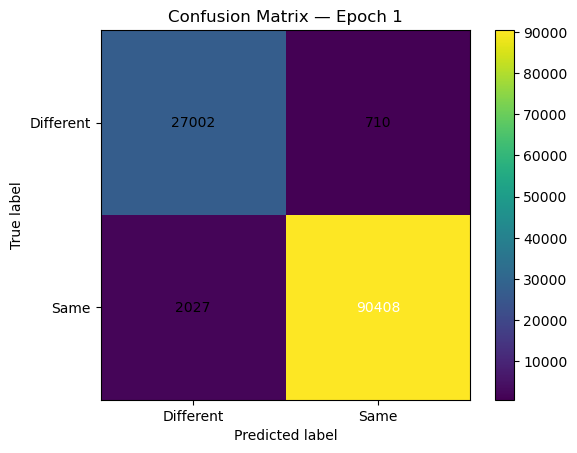

Epoch 02: Loss = 1.788730

--- Confusion Matrix (Epoch 2) ---
[[27038   674]
 [ 2008 90427]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.978
F1 Score:  0.985
TN: 27038, FP: 674, FN: 2008, TP: 90427


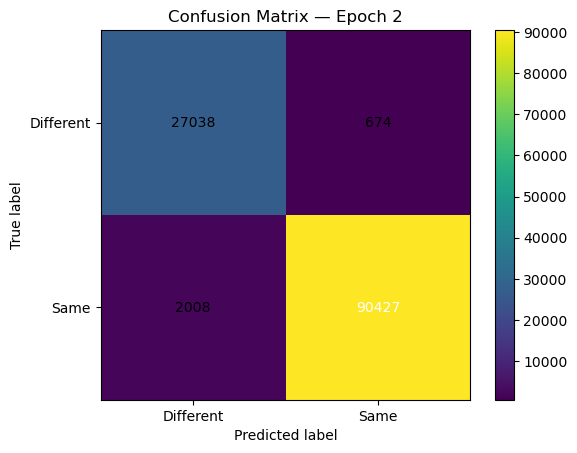

Epoch 03: Loss = 1.788175

--- Confusion Matrix (Epoch 3) ---
[[27022   690]
 [ 1987 90448]]
Accuracy:  0.978
Precision: 0.992
Recall:    0.979
F1 Score:  0.985
TN: 27022, FP: 690, FN: 1987, TP: 90448


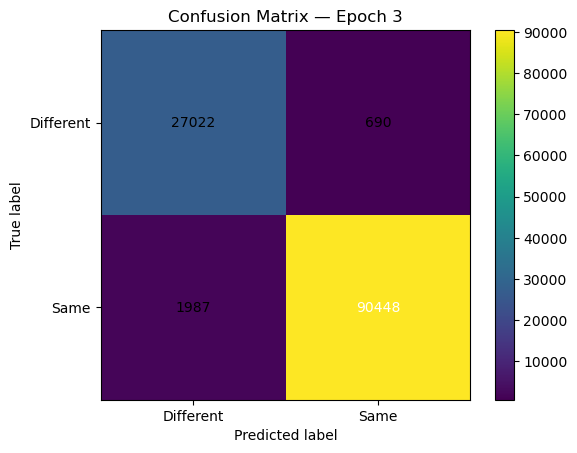

Epoch 04: Loss = 1.788525

--- Confusion Matrix (Epoch 4) ---
[[26983   729]
 [ 2143 90292]]
Accuracy:  0.976
Precision: 0.992
Recall:    0.977
F1 Score:  0.984
TN: 26983, FP: 729, FN: 2143, TP: 90292


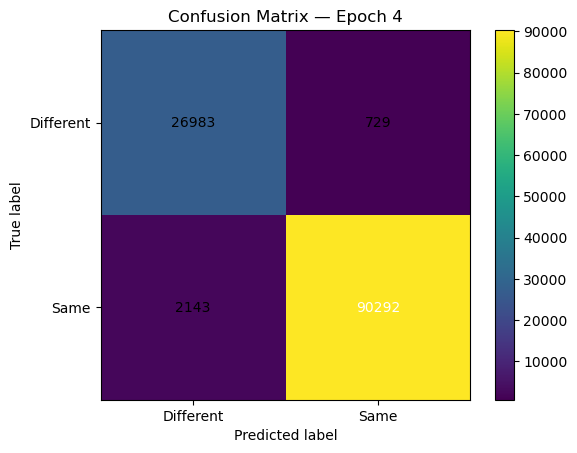

Epoch 05: Loss = 1.788592

--- Confusion Matrix (Epoch 5) ---
[[27020   692]
 [ 1997 90438]]
Accuracy:  0.978
Precision: 0.992
Recall:    0.978
F1 Score:  0.985
TN: 27020, FP: 692, FN: 1997, TP: 90438


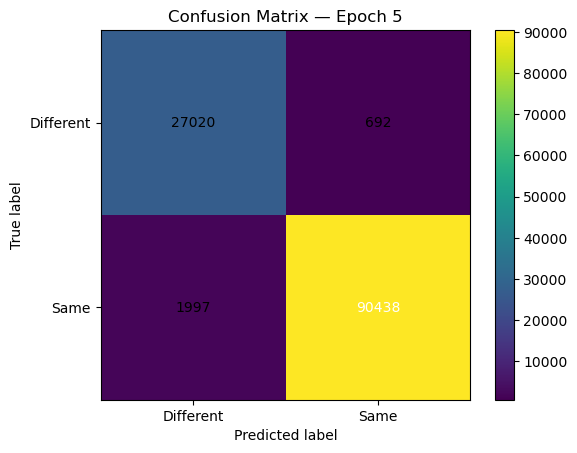

Epoch 06: Loss = 1.788271

--- Confusion Matrix (Epoch 6) ---
[[27062   650]
 [ 2119 90316]]
Accuracy:  0.977
Precision: 0.993
Recall:    0.977
F1 Score:  0.985
TN: 27062, FP: 650, FN: 2119, TP: 90316


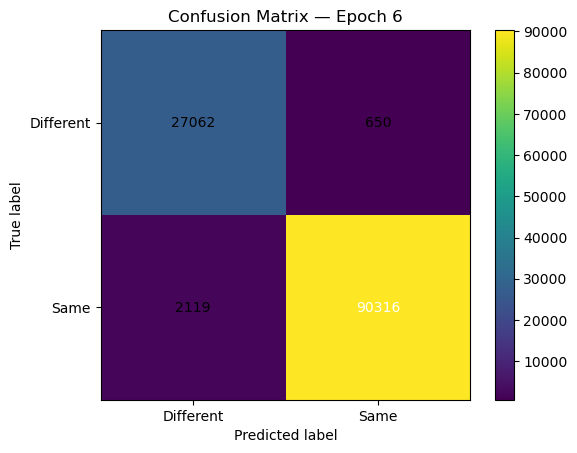

Epoch 07: Loss = 1.788568

--- Confusion Matrix (Epoch 7) ---
[[27038   674]
 [ 2073 90362]]
Accuracy:  0.977
Precision: 0.993
Recall:    0.978
F1 Score:  0.985
TN: 27038, FP: 674, FN: 2073, TP: 90362


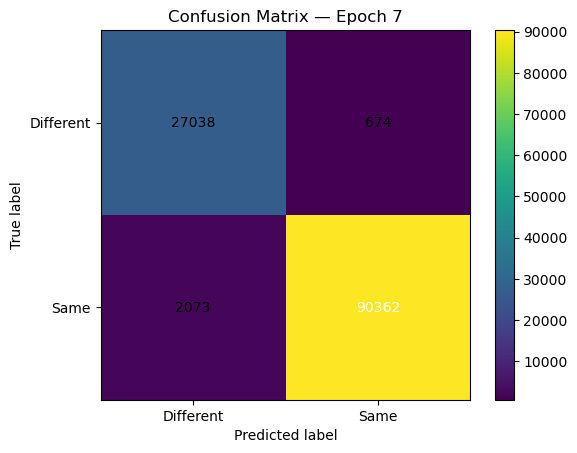

Epoch 08: Loss = 1.788537

--- Confusion Matrix (Epoch 8) ---
[[27042   670]
 [ 1947 90488]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.979
F1 Score:  0.986
TN: 27042, FP: 670, FN: 1947, TP: 90488


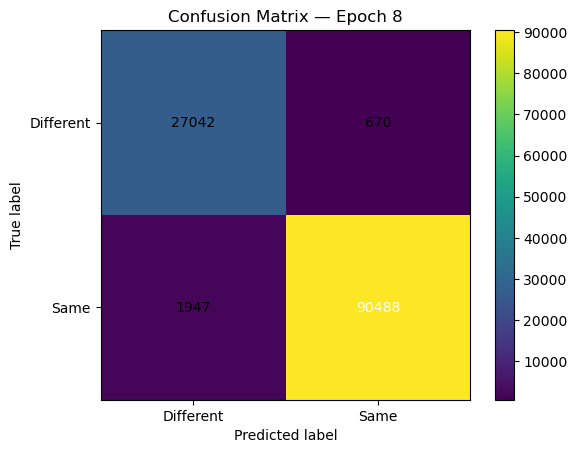

Epoch 09: Loss = 1.788616

--- Confusion Matrix (Epoch 9) ---
[[27026   686]
 [ 1950 90485]]
Accuracy:  0.978
Precision: 0.992
Recall:    0.979
F1 Score:  0.986
TN: 27026, FP: 686, FN: 1950, TP: 90485


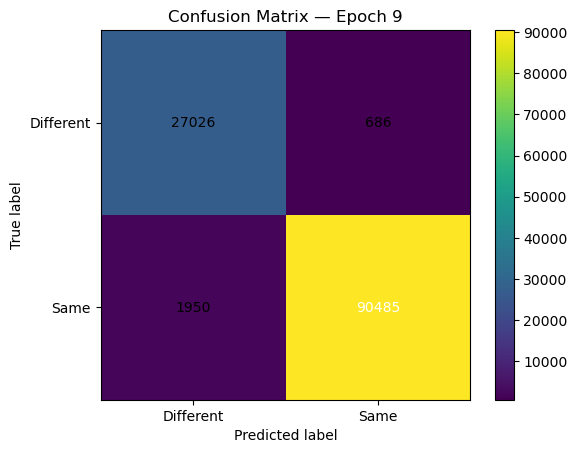

Epoch 10: Loss = 1.788531

--- Confusion Matrix (Epoch 10) ---
[[27062   650]
 [ 1994 90441]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.978
F1 Score:  0.986
TN: 27062, FP: 650, FN: 1994, TP: 90441


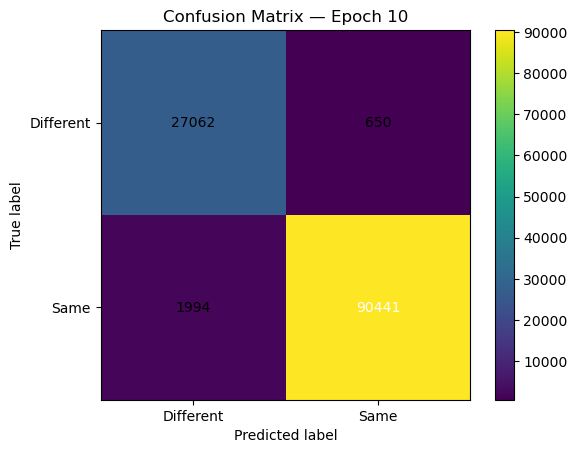

Epoch 11: Loss = 1.788728

--- Confusion Matrix (Epoch 11) ---
[[27076   636]
 [ 2054 90381]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.978
F1 Score:  0.985
TN: 27076, FP: 636, FN: 2054, TP: 90381


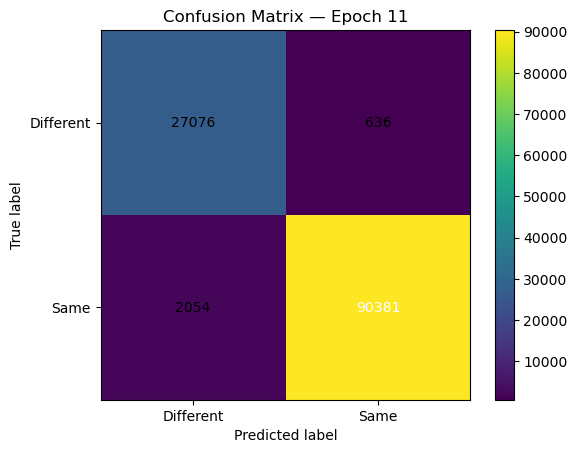

Epoch 12: Loss = 1.788202

--- Confusion Matrix (Epoch 12) ---
[[27064   648]
 [ 1921 90514]]
Accuracy:  0.979
Precision: 0.993
Recall:    0.979
F1 Score:  0.986
TN: 27064, FP: 648, FN: 1921, TP: 90514


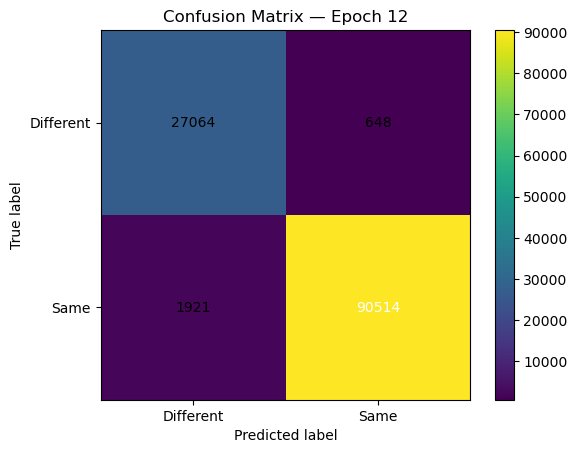

Epoch 13: Loss = 1.788491

--- Confusion Matrix (Epoch 13) ---
[[27077   635]
 [ 1942 90493]]
Accuracy:  0.979
Precision: 0.993
Recall:    0.979
F1 Score:  0.986
TN: 27077, FP: 635, FN: 1942, TP: 90493


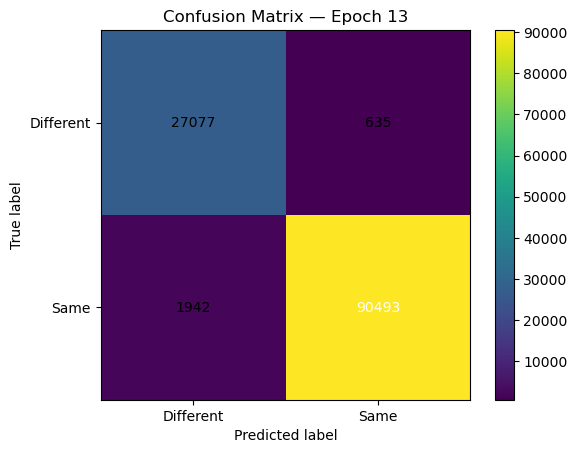

Epoch 14: Loss = 1.788338

--- Confusion Matrix (Epoch 14) ---
[[27038   674]
 [ 2040 90395]]
Accuracy:  0.977
Precision: 0.993
Recall:    0.978
F1 Score:  0.985
TN: 27038, FP: 674, FN: 2040, TP: 90395


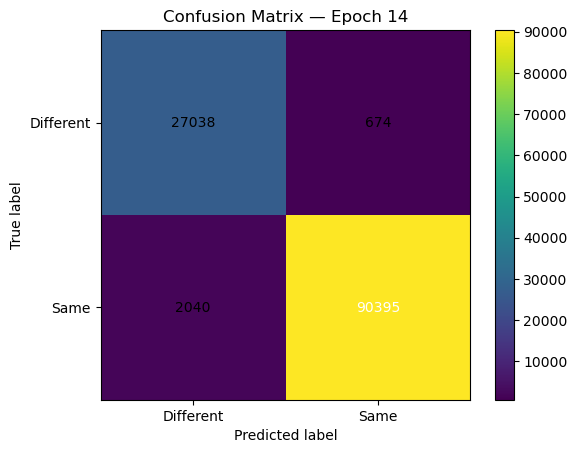

Epoch 15: Loss = 1.788387

--- Confusion Matrix (Epoch 15) ---
[[27083   629]
 [ 1959 90476]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.979
F1 Score:  0.986
TN: 27083, FP: 629, FN: 1959, TP: 90476


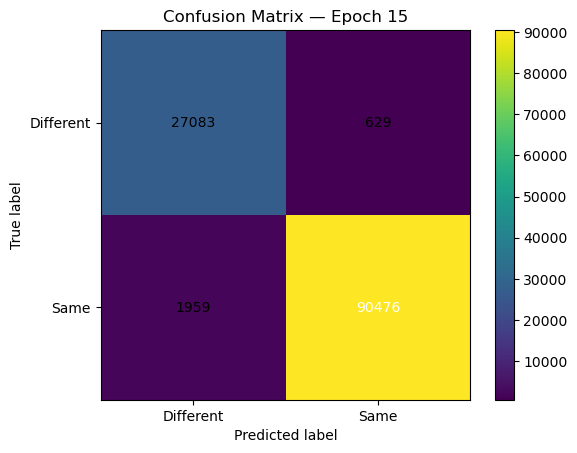

Epoch 16: Loss = 1.788496

--- Confusion Matrix (Epoch 16) ---
[[27034   678]
 [ 1968 90467]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.979
F1 Score:  0.986
TN: 27034, FP: 678, FN: 1968, TP: 90467


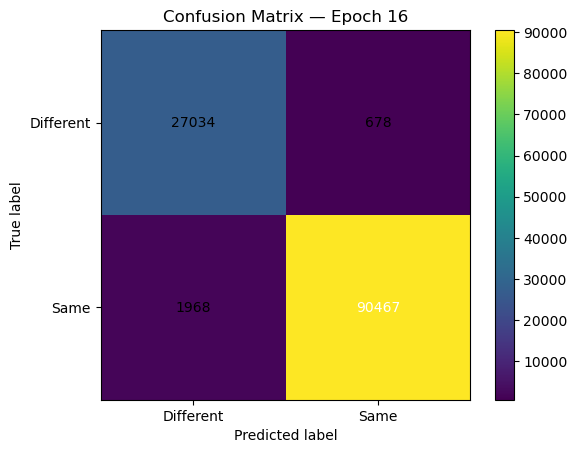

Epoch 17: Loss = 1.788299

--- Confusion Matrix (Epoch 17) ---
[[27048   664]
 [ 2013 90422]]
Accuracy:  0.978
Precision: 0.993
Recall:    0.978
F1 Score:  0.985
TN: 27048, FP: 664, FN: 2013, TP: 90422


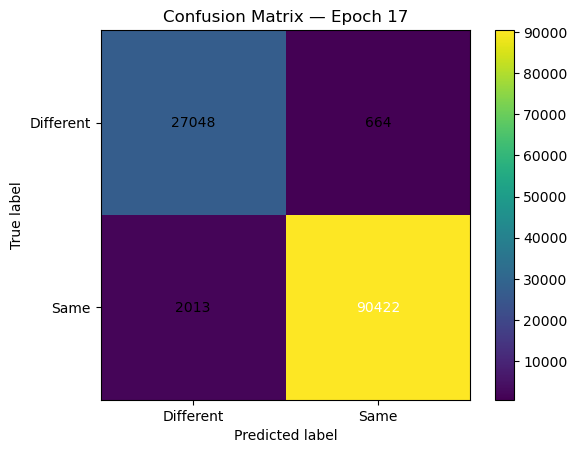

KeyboardInterrupt: 

In [29]:
main_model = main_model.to("cuda")
#main_history = train_pairwise_model(main_model, loader, main_optimizer, scheduler, num_epochs=100, device='cuda')
main_history = train_pairwise_model(main_model, loader, main_optimizer, num_epochs=100, device='cuda')

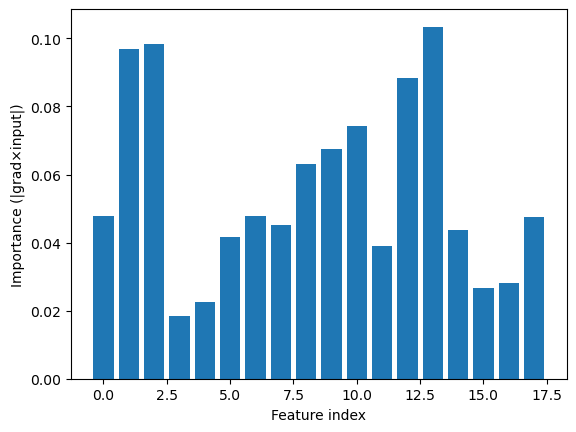

In [30]:
def feature_importance_gradient_x_input(model, batch, device='cuda'):
    model.eval()
    X, ex_id, counts, event_ids_list = batch
    X = X.to(device)
    ex_id = ex_id.to(device)
    
    # Enable gradient tracking on input features
    X = X.clone().detach().requires_grad_(True)
    
    # Forward pass
    pred_probs, mask = model(X, ex_id, counts)
    
    # You can pick a target statistic — e.g., sum over all predicted link probabilities
    # (so you get an importance signal for all dimensions)
    loss = pred_probs.sum()
    
    # Backpropagate
    model.zero_grad()
    loss.backward()
    
    # Gradient × Input
    grad_x_input = (X.grad * X).abs()
    
    # Aggregate per-feature importance across all time groups in the batch
    importance = grad_x_input.mean(dim=0).detach().cpu()
    
    return importance

total_imp = np.zeros(18)

for i in range(1000):
    imp = feature_importance_gradient_x_input(main_model, next(iter(loader))).numpy()
    norm_imp = imp / np.sum(imp)
    total_imp += norm_imp

plt.bar(range(18), total_imp / np.sum(total_imp))
plt.xlabel("Feature index")
plt.ylabel("Importance (|grad×input|)")
plt.show()

In [20]:
def collapse_tensor_to_clusters(similarity_tensor, threshold=0.5):
    """
    Collapses a similarity tensor into a 1D array of cluster assignments.

    Args:
        similarity_tensor (torch.Tensor or np.ndarray): A square matrix
            where similarity_tensor[i, j] represents the predicted relationship
            (similarity) between object i and object j.
        threshold (float): The similarity threshold above which two objects
            are considered to be in the same cluster.

    Returns:
        np.ndarray: A 1D array where each element `array[i]` is the cluster ID
            for the object `i`. Cluster IDs are assigned contiguously starting from 0.
    """
    if isinstance(similarity_tensor, torch.Tensor):
        similarity_matrix = similarity_tensor.cpu().numpy()
    else:
        similarity_matrix = np.asarray(similarity_tensor)

    num_objects = similarity_matrix.shape[0]

    if num_objects == 0:
        return np.array([], dtype=int)

    parent = list(range(num_objects))

    def find(i):
        if parent[i] == i:
            return i
        parent[i] = find(parent[i])
        return parent[i]

    def union(i, j):
        root_i = find(i)
        root_j = find(j)
        if root_i != root_j:
            parent[root_j] = root_i
            return True
        return False

    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            if similarity_matrix[i, j] > threshold:
                union(i, j)

    cluster_id_map = {}
    next_cluster_id = 0
    result_clusters = np.zeros(num_objects, dtype=int)

    for i in range(num_objects):
        root = find(i)
        if root not in cluster_id_map:
            cluster_id_map[root] = next_cluster_id
            next_cluster_id += 1
        result_clusters[i] = cluster_id_map[root]

    return result_clusters


def renumber_clusters(cluster_assignments):
    """
    Renumber cluster assignments to be incremental, starting from 0.

    Args:
        cluster_assignments (np.ndarray): A 1D NumPy array representing
                                          cluster assignments, e.g., [0, 2, 0, 1, 1].

    Returns:
        np.ndarray: A 1D NumPy array with renumbered cluster assignments,
                    e.g., [0, 1, 0, 2, 2].
    """
    if isinstance(cluster_assignments, tuple) and len(cluster_assignments) == 1 and isinstance(cluster_assignments[0], np.ndarray):
        cluster_assignments = cluster_assignments[0]
    elif not isinstance(cluster_assignments, np.ndarray):
        cluster_assignments = np.asarray(cluster_assignments)

    if cluster_assignments.size == 0:
        return np.array([], dtype=int)

    seen_clusters = {} # Maps old_id -> new_id
    next_new_id = 0
    renumbered_assignments = np.zeros_like(cluster_assignments, dtype=int)

    for i, old_id in enumerate(cluster_assignments):
        if old_id not in seen_clusters:
            seen_clusters[old_id] = next_new_id
            next_new_id += 1
        renumbered_assignments[i] = seen_clusters[old_id]

    return renumbered_assignments

def evaluate_pattern_finder(
    model, dataset, true_origins, num_samples=5
):

    model.train()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_example_batch)

    predictions = []
    true_patterns = []
    failures = []

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, ex_id, counts, event_ids_list = data
            #print(data[3], all_group_origins[i])
            preds = torch.stack([model(X, ex_id, counts)[0] for _ in range(num_samples)], dim=0)
            probs = preds.mean(dim=0)

            final_pred = collapse_tensor_to_clusters(probs)
            pattern = renumber_clusters(event_ids_list)
            incorrect = sum(final_pred - pattern) != 0

            predictions.append(final_pred)
            true_patterns.append(pattern)
            if incorrect:
                failures.append(i)

    return predictions, true_patterns, failures

main_model = main_model.to("cpu")
predicted_patterns, true_patterns, failed_patterns = evaluate_pattern_finder(main_model, dataset, all_group_origins)

In [21]:
print(failed_patterns)

[7, 23, 28, 37, 42, 72, 81, 83, 85, 90, 115, 143, 154, 165, 167, 170, 192, 246, 249, 346, 362, 376, 381, 392, 439, 441]


[0 1 1 0] [0 1 1 0]
[True, False, False, False] [array([ 4,  8,  8,  4, 12, 12,  4,  4,  8,  4,  4,  4,  8,  4,  4,  8,  8,
        8,  4,  4,  8,  8,  8,  4,  4,  4, 12,  4,  8,  8, 12,  4,  8,  8,
        4,  8,  8,  4,  4,  8,  4,  4,  8,  8,  4,  4,  4,  4,  4,  4,  8,
        4,  4, 12]), array([2, 2, 2, 2, 2, 2]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


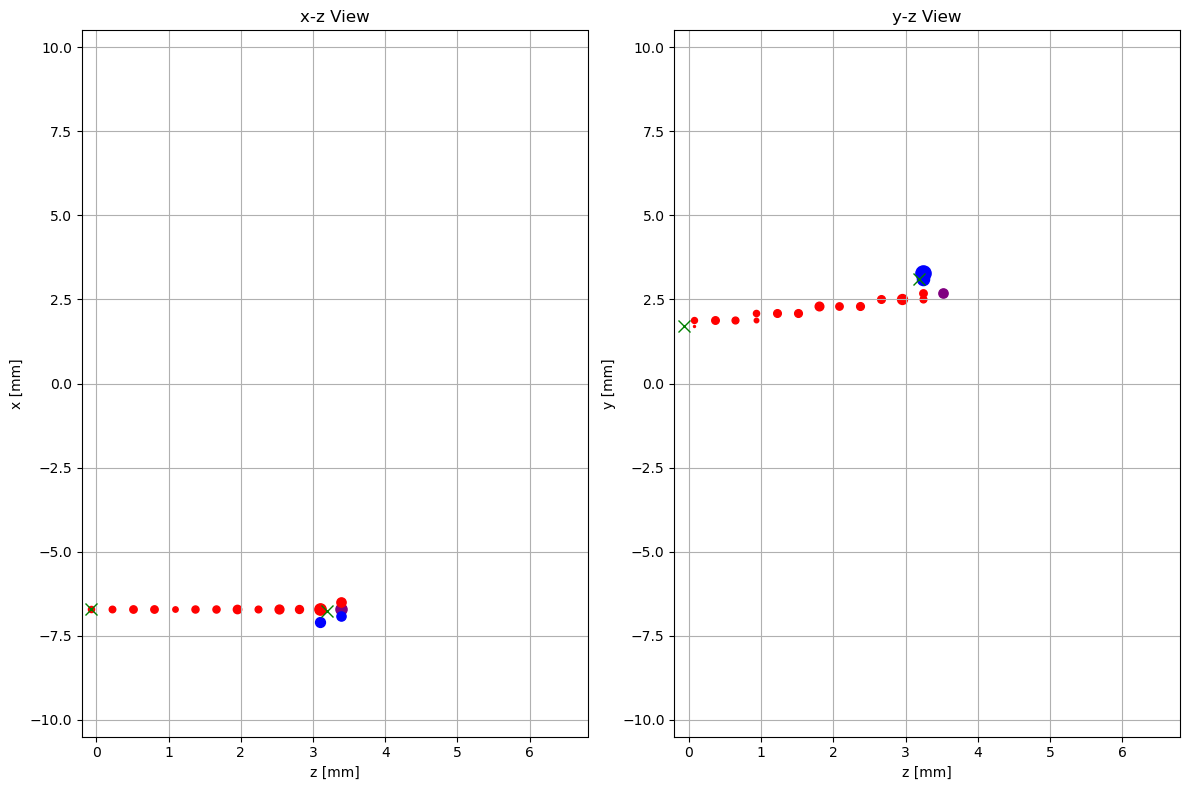

In [ ]:
window_num = 104

print(predicted_patterns[window_num] , true_patterns[window_num] )

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

particle_colors = {
    1: ("red", "Pion"),
    2: ("blue", "Muon"),
    3: ("purple", "Pion + Muon"),
    4: ("green", "Positron"),
}
default_color = ("gray", "Other")


window = all_events[window_num]
features = all_event_features[window_num]
positions = [group[:, :2] for group in window]
energies = [group[:, 3] for group in window]
pdgs = [group[:, 5].astype(int) for group in window]
hViews = [group[:, 2].astype(int) for group in window]
group_energies = [group[:, 11] for group in window]
event_nums = all_group_origins[window_num]
recon_endpoints = [[(feature[9],feature[10],feature[11]),(feature[12],feature[13],feature[14])] for feature in features]

isPositron = [bool(feature[17]) for feature in features]
print(isPositron, pdgs)




for group_num in range(len(window)):

    #if group_num not in [3]:
    #    continue

    if isPositron[group_num]:

        view0 = (hViews[group_num] == 0).astype(float)
        view1 = (hViews[group_num] == 1).astype(float)

        particle_stack = np.stack([positions[group_num][:, 0], positions[group_num][:, 1], energies[group_num], view0, view1, group_energies[group_num]], axis=1)
        particle_track = torch.tensor(particle_stack, dtype=torch.float)
        data_particle = Data(x=particle_track)
        data_particle.batch = torch.zeros(data_particle.x.shape[0], dtype=torch.long)
        data_particle.group_type = torch.tensor([4], dtype=torch.int)
        endpoints = torch.stack([eplus_endpoint_model(data_particle) for _ in range(10)], dim=0)
        #endpoints = endpoints.mean(dim=0).squeeze(0)
        #print(endpoints)
        print(endpoints.mean(dim=0))
        #print(recon_endpoints)
        print(data_particle.group_type)
        print()

    for i in range(2):  # 0 = x view, 1 = y view
        ax = axs[i]
        view_mask = (hViews[group_num] == i)
        view_indices = np.where(view_mask)[0]

        h2D = positions[group_num][view_mask]
        hEs = energies[group_num][view_mask]
        hPDGs_view = pdgs[group_num][view_mask]

        #print()
        #print(hPDGs_view)

        colors = [particle_colors.get(pdg, default_color)[0] for pdg in hPDGs_view]
        #if predicted_patterns[window_num][group_num] == 0:
        #    colors = ["black" for _ in colors]
        #elif predicted_patterns[window_num][group_num] == 1:
        #    colors = ["darkorange" for _ in colors]

        for j, (x_or_y, z) in enumerate(h2D):
            ax.scatter(z, x_or_y, c=colors[j], s=100 * hEs[j])

        # Plot endpoints (true and predicted)
        for j in range(2):  # each endpoint
            ax.plot(
                recon_endpoints[group_num][j][2], recon_endpoints[group_num][j][i],
                marker='x', color='green', markersize=8,
                label=f"Predicted Endpoint {j}" if i == 0 else None
            )
            #print((recon_endpoints[group_num][j][2], recon_endpoints[group_num][j][i]),j)

        #ax.legend(handles=legend_patches, loc='upper right')
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]" if i == 0 else "y [mm]")
        ax.set_title(f"{'x' if i == 0 else 'y'}-z View")
        ax.grid(True)
        ax.set_xlim(-0.2, 6.8)
        ax.set_ylim(-10.5, 10.5)

plt.tight_layout()
plt.show()

In [ ]:
#torch.save(main_model.state_dict(), '/mnt/e/testML/patternFinderV2.pth')

In [19]:
main_model = GroupAffinityModel(in_channels=18, hidden_channels=128, encoder_layers=2, dropout=0.05)
main_model.load_state_dict(torch.load('/mnt/e/testML/patternFinderV1.pth'))

<All keys matched successfully>